<a href="https://colab.research.google.com/github/pranav033-ctrl/Pnuenmonia-Detection-Using-CNN-based-Pre-trained-Models/blob/main/Pnueumonia_Detection_using_Pre_trained_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! pip install -q kaggle

In [12]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ppranav033","key":"ea3bc2c44edac99130862f19e1ed308c"}'}

In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-21 20:52:33          14395  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8667  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3851  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3229  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [17]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 31.7MB/s]



In [ ]:
! unzip chest-xray-pneumonia.zip

In [19]:
!pwd

/content


In [20]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [ ]:
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

In [22]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [23]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [24]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [25]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


In [26]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
test_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [28]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

In [30]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [31]:
base_model.trainable = False

In [32]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [33]:
len(model.trainable_variables)

8

In [34]:
initial_epochs = 20

In [35]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

326/326 [==============================] - 83s 136ms/step - loss: 0.8104 - accuracy: 0.7391 - val_loss: 0.6247 - val_accuracy: 0.6875
Epoch 2/20
326/326 [==============================] - 43s 130ms/step - loss: 0.5166 - accuracy: 0.8376 - val_loss: 0.6493 - val_accuracy: 0.6875
Epoch 3/20
326/326 [==============================] - 43s 131ms/step - loss: 0.4004 - accuracy: 0.8733 - val_loss: 0.9668 - val_accuracy: 0.6250
Epoch 4/20
326/326 [==============================] - 43s 130ms/step - loss: 0.3704 - accuracy: 0.8894 - val_loss: 0.9307 - val_accuracy: 0.6875
Epoch 5/20
326/326 [==============================] - 43s 130ms/step - loss: 0.3283 - accuracy: 0.8992 - val_loss: 0.8948 - val_accuracy: 0.6875
Epoch 6/20
326/326 [==============================] - 43s 130ms/step - loss: 0.2982 - accuracy: 0.9135 - val_loss: 1.0210 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 43s 130ms/step - loss: 0.2919 - accuracy: 0.9158 - val_loss: 1.0711 - val_accuracy: 0.6

In [36]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 5s 122ms/step - loss: 0.7336 - accuracy: 0.7901


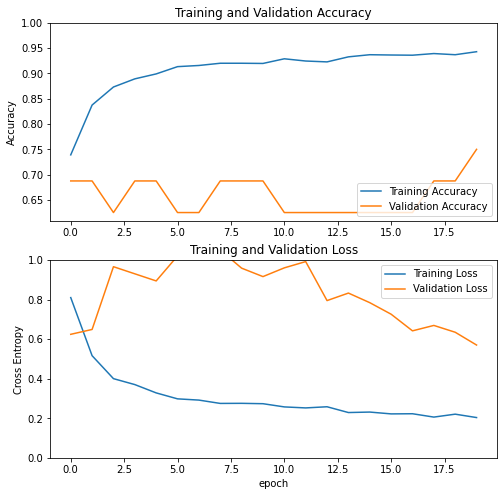

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 42

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [40]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [41]:
len(model.trainable_variables)

337

In [42]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/40
326/326 [==============================] - 130s 335ms/step - loss: 0.4152 - accuracy: 0.8723 - val_loss: 0.6458 - val_accuracy: 0.6875
Epoch 21/40
326/326 [==============================] - 108s 329ms/step - loss: 0.2331 - accuracy: 0.9291 - val_loss: 0.2925 - val_accuracy: 0.9375
Epoch 22/40
326/326 [==============================] - 108s 329ms/step - loss: 0.1924 - accuracy: 0.9488 - val_loss: 0.2273 - val_accuracy: 0.8750
Epoch 23/40
326/326 [==============================] - 108s 330ms/step - loss: 0.1526 - accuracy: 0.9628 - val_loss: 0.1530 - val_accuracy: 1.0000
Epoch 24/40
326/326 [==============================] - 108s 330ms/step - loss: 0.1396 - accuracy: 0.9705 - val_loss: 0.2685 - val_accuracy: 0.8125
Epoch 25/40
326/326 [==============================] - 108s 330ms/step - loss: 0.1340 - accuracy: 0.9703 - val_loss: 0.1629 - val_accuracy: 0.9375
Epoch 26/40
326/326 [==============================] - 108s 330ms/step - loss: 0.1164 - accuracy: 0.9768 - val_loss: 0

In [43]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 5s 123ms/step - loss: 1.2159 - accuracy: 0.7788


In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

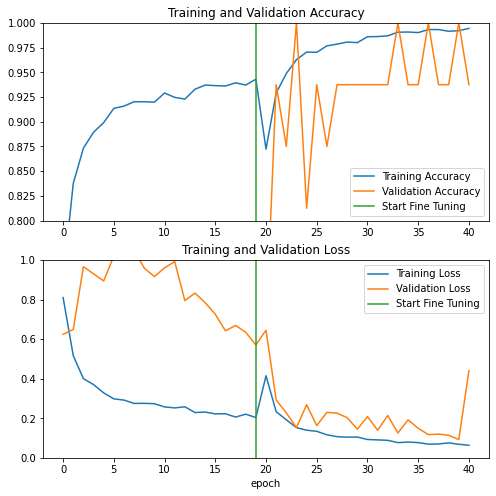

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
model.save('/')

INFO:tensorflow:Assets written to: /assets
